In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import itertools
import collections

%matplotlib notebook

In [2]:
class BS:
    def __init__(self, N, network, random_relations=False, species_ids=None, fitnesses=None):
        self.N = N
        self.network = network
        self.node_idx = N
        
        # create graph
        if network[0] == "watts-strogatz":
            (_, k, p) = network
            self.g = nx.watts_strogatz_graph(N, k, p)
            
            if species_ids is None:
                species_ids = range(N)
            if fitnesses is None:
                fitnesses = np.random.random(N)
            if random_relations:
                random_indices = np.random.permutation(N)
                species_ids = species_ids[random_indices]
                fitnesses = fitnesses[random_indices]
            for node in self.g:
                self.g.nodes[node]["id"] = species_ids[node]
                self.g.nodes[node]["fitness"] = fitnesses[node]
    
    def species(self):
        return dict(self.g.nodes.data("id")).values()
    
    def fitness(self):
        return self.g.nodes.data("fitness")
    
    def min_fitness(self):
        return min(self.fitness(), key=lambda x: x[1])
    
    def max_fitness(self):
        return max(self.fitness(), key=lambda x: x[1])
    
    def sorted_fitness(self):
        return sorted(self.fitness(), key=lambda x: x[1])
    
    def mutate(self, node_id, new_species_id, fitness=None):
        if fitness is None:
            fitness = np.random.random()
        self.g.node[node_id]["fitness"] = fitness
        self.g.node[node_id]["id"] = new_species_id


In [3]:
class Lattice:
    def __init__(self, dimensions, N, network, P):
        self.dimensions = dimensions
        self.N = N
        self.P = P
        self.species_idx = N
        
        # create lattice
        self.lattice = nx.grid_graph(list(dimensions), periodic=True)
        
        # create BS network in each point of the lattice
        fitnesses = np.random.random(N)
        for (i, point) in enumerate(self.lattice):
            self.lattice.node[point]["BS"] = BS(N, network, species_ids=range(N*i, N*(i+1)), fitnesses=None)
            

    def __getitem__(self, i):
        return self.lattice.node[i]["BS"]
    
    def mean_species(self):
        ids = set()
        for i, point in enumerate(self.lattice):
            ids = ids.union(set(self[point].species()))
        return len(ids) / (i + 1)

    def run(self, t_max):
        for t in range(t_max):
            for point in self.lattice:
                bs = self[point]
                lattice_neighbours = list(self.lattice[point])
                
                (i, f) = bs.min_fitness()
                
                nodes = [i] + list(bs.g[i])
                
                for node in nodes:
                    if np.random.random() < self.P:
                        # mutate
                        bs.mutate(node, self.species_idx)
                        self.species_idx += 1
                        
                    else:
                        # die + migrate
                        migrate_from = lattice_neighbours[np.random.randint(0, len(lattice_neighbours))]
                        for n_id, s_id in self[migrate_from].g.nodes.data("id"):
                            if s_id not in bs.species():
                                bs.mutate(node, s_id, fitness=self[migrate_from].g.node[n_id]["fitness"])
                                break
    
    def draw(self):
        nx.draw(self.lattice, with_labels=True)
        
    def nr_species(self):
        nr = np.empty(self.dimensions)
        for i in range(self.dimensions[0]):
            for j in range(self.dimensions[1]):
                nr[i, j] = len(self[(i,j)].species())
                
        return nr
    

            
    def area_curve(self, sampling_scheme='quadrats', log=True):
        # sampling_scheme = ['nested'|'quadrats']
        fig, ax = plt.subplots()

        if sampling_scheme == 'nested':
            area_curve = np.empty((self.dimensions[0],2))
            for s in range(1, self.dimensions[0]+1):
                species = set()
                for i in range(0, s):
                    for j in range(0, s):
                        species = species.union(self[(i,j)].species())

                nr = len(species)
                print(np.sum(self.nr_species()[:s,:s]), nr)
                area_curve[s-1] = (s**2, nr)
            print(area_curve)
            ax.plot(*area_curve.T, "o")

        elif sampling_scheme == 'quadrats':
            area_curve = collections.OrderedDict()
            sd = []
            for grain_size in range(1, max(self.dimensions)+1):
                assert self.dimensions[0] == self.dimensions[1]
                means = []
                i = 0
                for interval_i in range(0, self.dimensions[0]-grain_size+1):
                    for interval_j in range(0, self.dimensions[1]-grain_size+1):
                        species = set()
                        for i,j in np.ndindex((grain_size,grain_size)):
                            ii = interval_i + i
                            jj = interval_j + j
                            species = species.union(self[(ii,jj)].species())
                            i += 1

                        means.append(len(species))
                
                area_curve[grain_size**2] = np.mean(means)
                sd.append(np.std(means)*1.96/np.sqrt(i))
                print('grain size: %i, mean: %0.3f'% (grain_size, np.mean(means)))
            ax.errorbar(list(area_curve.keys()), list(area_curve.values()), yerr = sd, marker="x")
        
        ax.set_xlabel("Area")
        ax.set_ylabel("Number of species")
        
        if log:
            ax.set_xscale("log")
            ax.set_yscale("log")
            
        power = (np.log10(area_curve[self.dimensions[0]**2]) - np.log10(area_curve[1])) / (np.log10(self.dimensions[0]**2) - np.log10(1))
        print("power: {}".format(power))
        
    

In [4]:
l = Lattice((10,10), 10, ("watts-strogatz", 3, 0), 1/3)
print(l[(0,0)].g.nodes.data())
print(l[(0,1)].g.nodes.data())

[(0, {'id': 0, 'fitness': 0.8360821987569629}), (1, {'id': 1, 'fitness': 0.4086378910850761}), (2, {'id': 2, 'fitness': 0.8751204135267039}), (3, {'id': 3, 'fitness': 0.45525782219792765}), (4, {'id': 4, 'fitness': 0.7926725136458446}), (5, {'id': 5, 'fitness': 0.1784210846675548}), (6, {'id': 6, 'fitness': 0.18144529362166006}), (7, {'id': 7, 'fitness': 0.5801604883732846}), (8, {'id': 8, 'fitness': 0.7124321689040891}), (9, {'id': 9, 'fitness': 0.7710684556463854})]
[(0, {'id': 10, 'fitness': 0.44225060619078305}), (1, {'id': 11, 'fitness': 0.35611313864686167}), (2, {'id': 12, 'fitness': 0.3894211312069523}), (3, {'id': 13, 'fitness': 0.7888006572808799}), (4, {'id': 14, 'fitness': 0.4814919373752359}), (5, {'id': 15, 'fitness': 0.7534184128968293}), (6, {'id': 16, 'fitness': 0.9029560624113202}), (7, {'id': 17, 'fitness': 0.23552287272472927}), (8, {'id': 18, 'fitness': 0.30231776808052424}), (9, {'id': 19, 'fitness': 0.0162435229491521})]


CPU times: user 2.09 s, sys: 10.2 ms, total: 2.1 s
Wall time: 2.05 s
grain size: 1, mean: 99.990
grain size: 2, mean: 284.617
grain size: 3, mean: 552.828
grain size: 4, mean: 908.490
grain size: 5, mean: 1344.194
grain size: 6, mean: 1854.640
grain size: 7, mean: 2420.000
grain size: 8, mean: 2998.000
grain size: 9, mean: 3534.750
grain size: 10, mean: 4043.000
power: 0.803373586476741


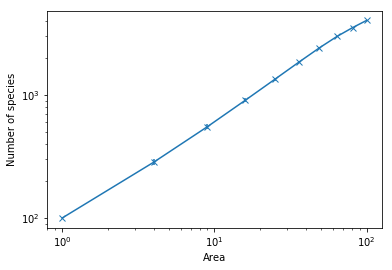

In [6]:
l = Lattice((10,10), 100, ("watts-strogatz", 3, 0), 1/3)
%time l.run(100)

l.area_curve("quadrats")

<IPython.core.display.Javascript object>


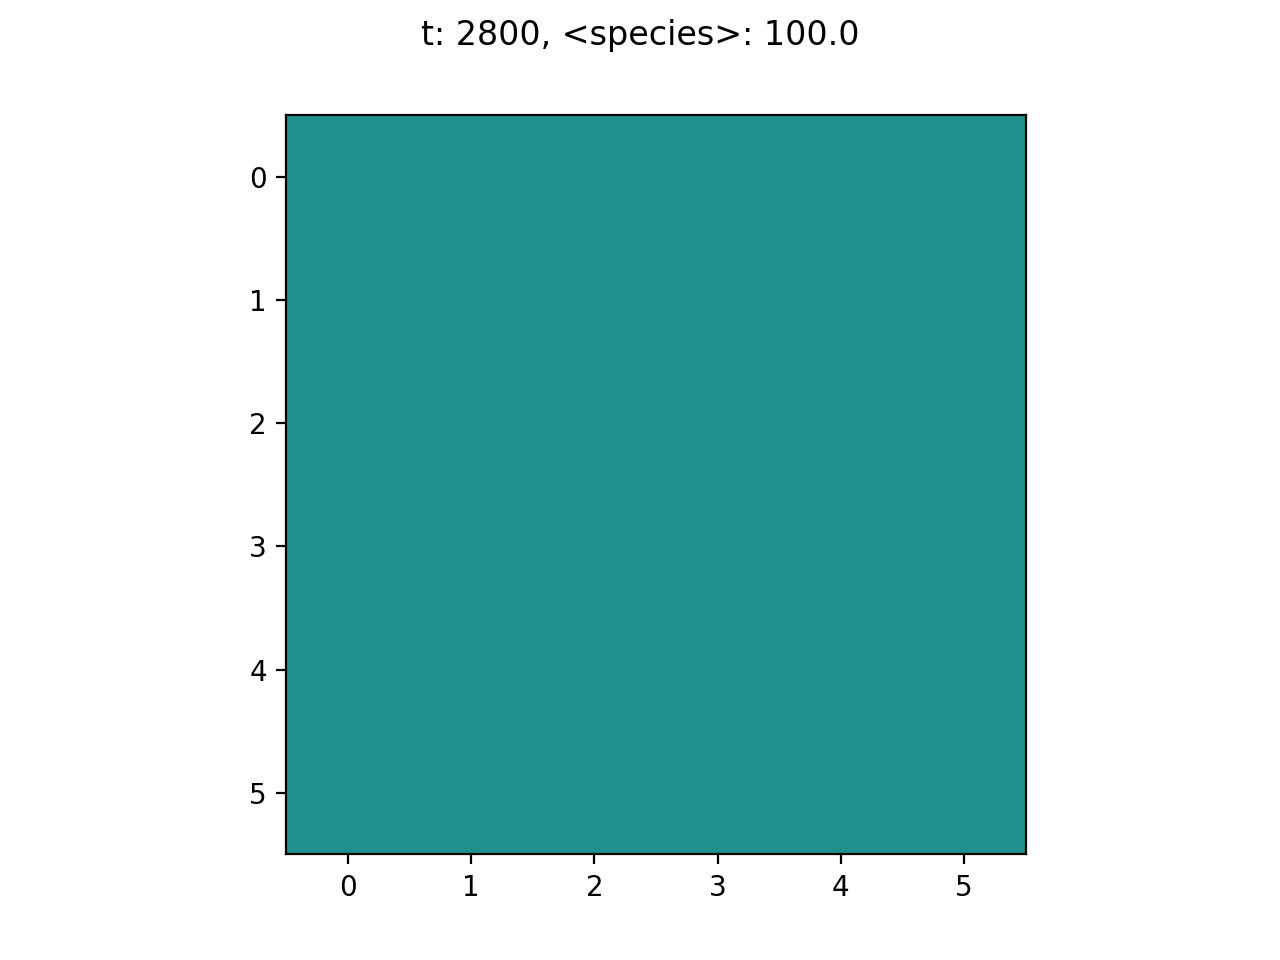

In [72]:
dimensions = (6,6)
l = Lattice(dimensions, 100, ("watts-strogatz", 3, 0), 0.1)

nr_species = np.zeros(dimensions)

fig = plt.figure()
im = plt.imshow(nr_species, vmin=0, vmax=200)

def init():
     pass

def animate(i):
    l.run(100)
    
    fig.suptitle("t: {}, <species>: {}".format((i+1) * 100, np.mean(l.nr_species())))
    im.set_data(l.nr_species())
    
    return im 

ani = animation.FuncAnimation(fig, animate, np.arange(100), init_func=init, interval=100, repeat=False, blit=True, save_count=1000)